In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Tue Jan 16 21:40:35 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   33C    P0    44W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.normal_prior import Prior
from model.latent.swae_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(10):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.16-8/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 8
-rw-rw-r-- 1 scpark scpark 40  1월 16 21:40 events.out.tfevents.1705408791.GPUSVR11
-rw-rw-r-- 1 scpark scpark 40  1월 16 21:39 events.out.tfevents.1705408755.GPUSVR11


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=256, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


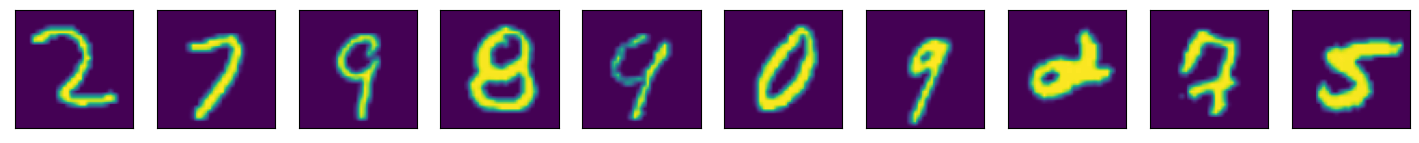

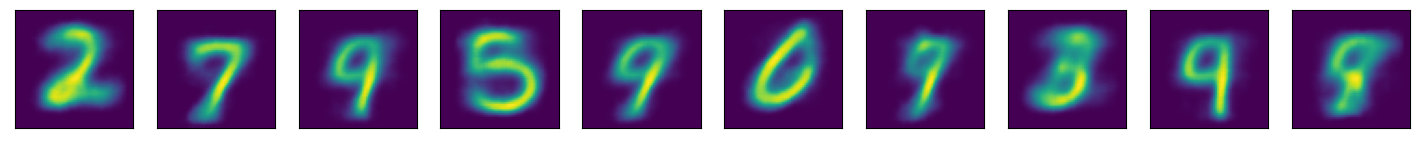

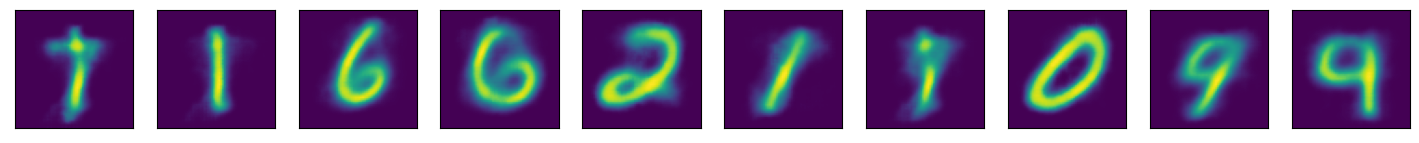

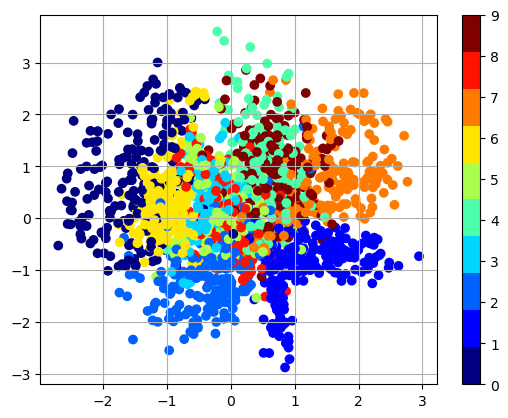

4001
swae_loss 0.021274273190647362
recon_loss 0.14698172360658646
4002
swae_loss 0.01956385252997279
recon_loss 0.1389114186167717
4003
swae_loss 0.017199995880946516
recon_loss 0.14619995951652526
4004
swae_loss 0.016657450702041388
recon_loss 0.14493828564882277
4005
swae_loss 0.017035307921469213
recon_loss 0.147511887550354
4006
swae_loss 0.01418355545029044
recon_loss 0.14311230480670928
4007
swae_loss 0.01708209291100502
recon_loss 0.1392886996269226
4008
swae_loss 0.015477839112281799
recon_loss 0.13533416390419006
4009
swae_loss 0.02000980582088232
recon_loss 0.13419457972049714
4010
swae_loss 0.017138245142996313
recon_loss 0.1389939770102501
4011
swae_loss 0.02178636835888028
recon_loss 0.14806687086820602
4012
swae_loss 0.01868316186591983
recon_loss 0.14412780106067657
4013
swae_loss 0.02021610429510474
recon_loss 0.1417874276638031
4014
swae_loss 0.01661184327676892
recon_loss 0.14684297293424606
4015
swae_loss 0.019156254082918166
recon_loss 0.14122286587953567
4016
swae

swae_loss 0.02025052346289158
recon_loss 0.14181502163410187
4126
swae_loss 0.0184909176081419
recon_loss 0.1379748910665512
4127
swae_loss 0.02092640269547701
recon_loss 0.14581431746482848
4128
swae_loss 0.025706184469163416
recon_loss 0.14571385085582733
4129
swae_loss 0.02163293994963169
recon_loss 0.14030515700578688
4130
swae_loss 0.0214008878916502
recon_loss 0.14524485617876054
4131
swae_loss 0.021676178276538848
recon_loss 0.15029203295707702
4132
swae_loss 0.015834934450685977
recon_loss 0.13809482157230377
4133
swae_loss 0.01823644256219268
recon_loss 0.14561835825443267
4134
swae_loss 0.01926220962777734
recon_loss 0.14245883971452714
4135
swae_loss 0.019457242731004954
recon_loss 0.14408579468727112
4136
swae_loss 0.016294770129024982
recon_loss 0.14744236022233964
4137
swae_loss 0.02272197687998414
recon_loss 0.1484849840402603
4138
swae_loss 0.01899823760613799
recon_loss 0.14288032203912734
4139
swae_loss 0.019314700458198785
recon_loss 0.1438794881105423
4140
swae_loss

4249
swae_loss 0.017059031501412393
recon_loss 0.15069645941257476
4250
swae_loss 0.016973505914211272
recon_loss 0.13978157341480255
4251
swae_loss 0.014286835119128228
recon_loss 0.13647324293851854
4252
swae_loss 0.01929943822324276
recon_loss 0.15204256474971772
4253
swae_loss 0.04846394006162882
recon_loss 0.14326552003622056
4254
swae_loss 0.019003901118412613
recon_loss 0.1356603890657425
4255
swae_loss 0.021030251774936913
recon_loss 0.1382518768310547
4256
swae_loss 0.022151194140315057
recon_loss 0.1480459451675415
4257
swae_loss 0.017848660703748465
recon_loss 0.15036747902631759
4258
swae_loss 0.021109035331755878
recon_loss 0.15123700648546218
4259
swae_loss 0.020147781632840634
recon_loss 0.14233285784721375
4260
swae_loss 0.022534927632659674
recon_loss 0.14005001485347748
4261
swae_loss 0.020133175048977138
recon_loss 0.14804672002792357
4262
swae_loss 0.018151139933615924
recon_loss 0.14905631244182588
4263
swae_loss 0.02022224087268114
recon_loss 0.14726267755031586
4

swae_loss 0.01771880090236664
recon_loss 0.1386770635843277
4374
swae_loss 0.020580003410577773
recon_loss 0.1430900886654854
4375
swae_loss 0.015794592443853617
recon_loss 0.13946054875850677
4376
swae_loss 0.018441840820014477
recon_loss 0.14192665219306946
4377
swae_loss 0.021541081927716733
recon_loss 0.14334260076284408
4378
swae_loss 0.01916387164965272
recon_loss 0.1412047728896141
4379
swae_loss 0.015953726321458816
recon_loss 0.14485471099615096
4380
swae_loss 0.02098516458645463
recon_loss 0.14372989237308503
4381
swae_loss 0.018300874531269072
recon_loss 0.14024122953414916
4382
swae_loss 0.020776973385363818
recon_loss 0.144236321747303
4383
swae_loss 0.01745911305770278
recon_loss 0.14177072495222093
4384
swae_loss 0.01761596482247114
recon_loss 0.14475473910570144
4385
swae_loss 0.01651350809261203
recon_loss 0.1431236207485199
4386
swae_loss 0.01886654021218419
recon_loss 0.1446751981973648
4387
swae_loss 0.019959353748708962
recon_loss 0.14032259285449983
4388
swae_loss

4497
swae_loss 0.01876489007845521
recon_loss 0.14050494879484177
4498
swae_loss 0.017601894959807397
recon_loss 0.14527227431535722
4499
swae_loss 0.023107774555683136
recon_loss 0.13982117623090745
4500
swae_loss 0.02153986319899559
recon_loss 0.14648884534835815
4501
swae_loss 0.016359380166977643
recon_loss 0.14261745810508727
4502
swae_loss 0.01789227994158864
recon_loss 0.14135280400514602
4503
swae_loss 0.017157102283090354
recon_loss 0.1495213747024536
4504
swae_loss 0.019283322244882585
recon_loss 0.13697720915079117
4505
swae_loss 0.0156679286621511
recon_loss 0.1488921105861664
4506
swae_loss 0.021052264049649237
recon_loss 0.14109438061714172
4507
swae_loss 0.01600745227187872
recon_loss 0.13337650299072265
4508
swae_loss 0.020531518384814262
recon_loss 0.1370893284678459
4509
swae_loss 0.020498127769678832
recon_loss 0.1356057718396187
4510
swae_loss 0.017400614731013776
recon_loss 0.14905961602926254
4511
swae_loss 0.017745748162269592
recon_loss 0.15309793800115584
4512


4621
swae_loss 0.017008012812584638
recon_loss 0.14109158515930176
4622
swae_loss 0.01801600120961666
recon_loss 0.1460586354136467
4623
swae_loss 0.01945669446140528
recon_loss 0.15309958010911942
4624
swae_loss 0.02032643500715494
recon_loss 0.13999106138944625
4625
swae_loss 0.017646248918026686
recon_loss 0.13809358924627305
4626
swae_loss 0.02013037810102105
recon_loss 0.14827421605587005
4627
swae_loss 0.017345496732741595
recon_loss 0.1446966141462326
4628
swae_loss 0.020405833050608634
recon_loss 0.14715132713317872
4629
swae_loss 0.02016206393018365
recon_loss 0.14267042577266692
4630
swae_loss 0.017041032016277314
recon_loss 0.13992426693439483
4631
swae_loss 0.01757615813985467
recon_loss 0.1425011485815048
4632
swae_loss 0.020969942305237056
recon_loss 0.14180380553007127
4633
swae_loss 0.016944055911153555
recon_loss 0.13758136481046676
4634
swae_loss 0.0213529740460217
recon_loss 0.14185922145843505
4635
swae_loss 0.0267337080091238
recon_loss 0.1427244707942009
4636
swae

4745
swae_loss 0.019030897598713636
recon_loss 0.14008765518665314
4746
swae_loss 0.01885439520701766
recon_loss 0.1364077225327492
4747
swae_loss 0.016725154127925634
recon_loss 0.1427648112177849
4748
swae_loss 0.017141735088080166
recon_loss 0.14384885281324386
4749
swae_loss 0.018487466685473918
recon_loss 0.14329541474580765
4750
swae_loss 0.017940325755625965
recon_loss 0.14608180224895478
4751
swae_loss 0.021768405009061097
recon_loss 0.13532956093549728
4752
swae_loss 0.021204679366201164
recon_loss 0.15204397439956666
4753
swae_loss 0.020466823410242797
recon_loss 0.13878534287214278
4754
swae_loss 0.019237613864243032
recon_loss 0.14275904297828673
4755
swae_loss 0.016335385758429764
recon_loss 0.13627457320690156
4756
swae_loss 0.019920672476291656
recon_loss 0.13739587217569352
4757
swae_loss 0.01641926048323512
recon_loss 0.14524268954992295
4758
swae_loss 0.015853121411055326
recon_loss 0.13935149759054183
4759
swae_loss 0.018178032152354716
recon_loss 0.13895766735076903

4869
swae_loss 0.01786625888198614
recon_loss 0.14092194586992263
4870
swae_loss 0.01885513626039028
recon_loss 0.1457466185092926
4871
swae_loss 0.01630560662597418
recon_loss 0.14160789996385575
4872
swae_loss 0.020268936362117528
recon_loss 0.15314023494720458
4873
swae_loss 0.01589345056563616
recon_loss 0.14501115381717683
4874
swae_loss 0.02330981185659766
recon_loss 0.1435915231704712
4875
swae_loss 0.019998413510620594
recon_loss 0.14189614355564117
4876
swae_loss 0.01719119297340512
recon_loss 0.14664363414049147
4877
swae_loss 0.01793362107127905
recon_loss 0.13929049372673036
4878
swae_loss 0.017878787219524385
recon_loss 0.1320227101445198
4879
swae_loss 0.015239971969276667
recon_loss 0.14592843800783156
4880
swae_loss 0.018574588187038898
recon_loss 0.1466786578297615
4881
swae_loss 0.019768670946359635
recon_loss 0.14125889539718628
4882
swae_loss 0.016466151643544435
recon_loss 0.13918495923280716
4883
swae_loss 0.02055643144994974
recon_loss 0.13950205594301224
4884
sw

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=len(data['x']))

            # Backward
            loss = 0
            for key in data.keys():
                if 'swae_loss' in key:
                    loss = loss + data[key] * 10
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=len(data['x']))
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        